# Autoregressive logistic regression

Replicate example on _Changes in evapotranspiration rates_ presented in: 

- B. Kedem and K. Fokianos, Regression models for time series analysis, 2002, p. 39
- A. Agresti, Categorical data analysis, 3rd ed., 2014, p. 474  

In [1]:
import pandas as pd

import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
print(pm.__version__)
import theano.tensor as tt
import patsy

import scipy.special as ss

3.5


In [2]:
SEED = 20180727

In [3]:
obs = [int(i) for i in '111111110001111100000001111000100000111111110011000000011111100000000011111110000000']
obs = np.asarray(obs)
print(obs)
print(obs.shape)

[1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 0 0 0 0 0 0 0]
(84,)


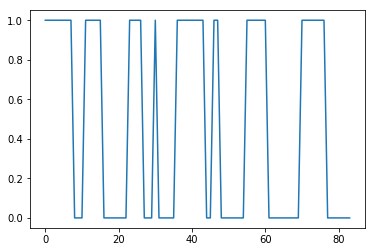

In [4]:
plt.plot(obs);

To build an autoregressive model, I use the observation at `t-1` as predictor for the observation at `t`

In [5]:
obs_t = obs[1:]
obs_t_minus_1 = obs[0:-1]

assert(obs_t.shape == obs_t_minus_1.shape)

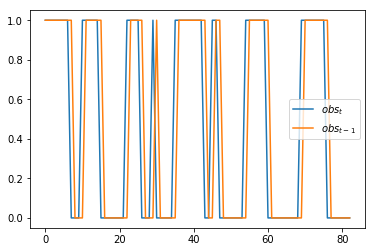

In [6]:
plt.plot(obs_t, label='$obs_t$')
plt.plot(obs_t_minus_1, label='$obs_{t-1}$')
plt.legend()
pass

In [7]:
df = pd.DataFrame({'t':np.arange(obs[2:].shape[0]),
                   'obs_t':obs[2:],
                   'obs_t_minus_1':obs[1:-1],
                   'obs_t_minus_2':obs[0:-2]})
df.head()

,t,obs_t,obs_t_minus_1,obs_t_minus_2
0,0,1,1,1
1,1,1,1,1
2,2,1,1,1
3,3,1,1,1
4,4,1,1,1


In [8]:
Y, X = patsy.dmatrices('obs_t ~ obs_t_minus_1', data=df)
Y.flatten(), X

(array([1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.]),
 DesignMatrix with shape (82, 2)
   Intercept  obs_t_minus_1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              1
           1              0
           1              0
           1              0
           1              1
           1              1
           1              1
           1              1
           1              1
           1              0
           1              0
           1              0
           1              0
           1              0
         

In [9]:
with pm.Model() as model:
    
    beta = pm.Normal('beta', mu=0, sd=100, shape=np.asarray(X).shape[1])
    
    p = pm.math.invlogit(pm.math.dot(np.asarray(X), beta))
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=Y.flatten())
    
    trace = pm.sample(draws=3000, tune=1000, chains=4, cores=2, random_seed=SEED, nuts_kwargs={'target_accept':0.90})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|████████████| 16000/16000 [00:12<00:00, 1270.66draws/s]


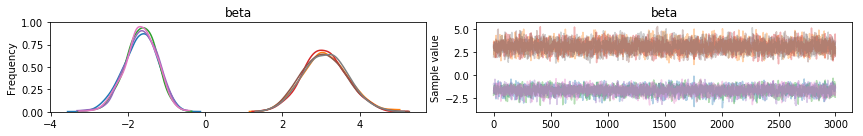

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta__0,-1.666932,0.423119,0.007038,-2.489516,-0.858281,3699.341544,1.000169
beta__1,3.107252,0.583504,0.009688,1.967446,4.248502,3734.152227,1.000296


In the Agresti's book the results are $(\alpha, \beta) = (-1.609, 2.996)$

In [12]:
with model:
    ppc = pm.sample_ppc(trace)
    
ppc['likelihood'].shape

100%|████████████████████████████████████| 3000/3000 [00:01<00:00, 1851.27it/s]


(3000, 82)

In [13]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.head()

,beta__0,beta__1
0,-1.686244,2.885313
1,-1.598194,3.122611
2,-1.575412,3.084934
3,-1.914505,3.705491
4,-2.029559,3.714082


In [14]:
trace_df.mean(axis=0)

beta__0   -1.666932
beta__1    3.107252
dtype: float64

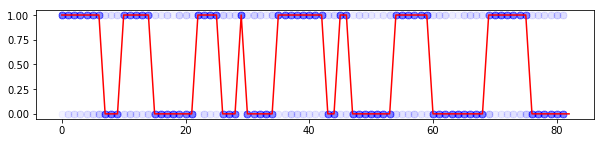

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

"""for beta in zip(trace_df['beta__0'][::10], trace_df['beta__1'][::10]):
    samples = np.random.binomial(1, ss.expit(np.dot(np.asarray(X), np.asarray(beta))), size=df.obs_t.shape[0])
    plt.plot(samples, alpha=0.008, color='blue', lw=1)"""

plt.plot(ppc['likelihood'][::50].T, color='blue', alpha=0.01, ls='none', marker='o', markersize=7, label='$PPC$')

#samples = np.random.binomial(1, ss.expit(np.dot(np.asarray(X), trace_df.mean(axis=0))), size=df.obs_t.shape[0])
#plt.plot(samples, color='blue', label='$PPC_{mean}$')
    
plt.plot(obs_t, color='red', label='$obs_t$')
pass

# The graph hints that the model is capturing the effect. However, beacuse of the sampling of the binomial distribution I have a lot of noise. The samples, in fact, can either be 0 or 1 and not something close t

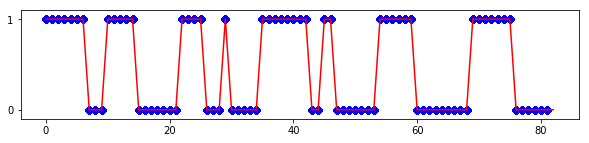

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))

for beta in zip(trace_df['beta__0'][::10], trace_df['beta__1'][::10]):
    p = ss.expit(np.dot(np.asarray(X), np.asarray(beta)))
    # By thresholding P, I remove the sampling error. In fact, a p=0.8 does not necessarly output a 1 in the binomial random sampling.
    # with the threshold p>=0.5 I obtain an array of zeros and ones
    plt.plot(p>=0.5, alpha=0.008, ls='none', marker='o', markersize=7, color='blue', lw=1)
    
plt.plot(obs_t, color='red', label='$obs_t$')
plt.ylim((-0.1, 1.1))
plt.yticks((0, 1))
pass